In [ ]:
#!pip install gym[atari]
#!pip install stable-baselines3[extra]

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [29]:
from stable_baselines3.common.env_util import make_atari_env
import pybullet_envs
import gym
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import make_vec_env

In [30]:
pybullet_envs.getList()

['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

In [31]:
def get_env(n_envs=16):
    # There already exists an environment generator that will make and wrap atari environments correctly.
    # We use 16 parallel processes
    env = make_vec_env('HalfCheetahBulletEnv-v0', n_envs=n_envs, seed=0)
    # Stack 4 frames
    env = VecFrameStack(env, n_stack=4)
    return env

In [32]:
env = get_env(1)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


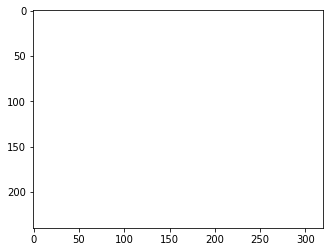

In [33]:
state = env.render(mode='rgb_array')
plt.imshow(state)

In [34]:
from typing import Any, Dict

import gym
import torch as th

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import Video


class VideoRecorderCallback(BaseCallback):
    def __init__(self, eval_env: gym.Env, render_freq: int, n_eval_episodes: int = 1, deterministic: bool = True):
        """
        Records a video of an agent's trajectory traversing ``eval_env`` and logs it to TensorBoard

        :param eval_env: A gym environment from which the trajectory is recorded
        :param render_freq: Render the agent's trajectory every eval_freq call of the callback.
        :param n_eval_episodes: Number of episodes to render
        :param deterministic: Whether to use deterministic or stochastic policy
        """
        super().__init__()
        self._eval_env = eval_env
        self._render_freq = render_freq
        self._n_eval_episodes = n_eval_episodes
        self._deterministic = deterministic

    def _on_step(self) -> bool:
        if self.n_calls % self._render_freq == 0:
            screens = []

            def grab_screens(_locals: Dict[str, Any], _globals: Dict[str, Any]) -> None:
                """
                Renders the environment in its current state, recording the screen in the captured `screens` list

                :param _locals: A dictionary containing all local variables of the callback's scope
                :param _globals: A dictionary containing all global variables of the callback's scope
                """
                screen = self._eval_env.render(mode="rgb_array")
                # PyTorch uses CxHxW vs HxWxC gym (and tensorflow) image convention
                screens.append(screen.transpose(2, 0, 1))

            evaluate_policy(
                self.model,
                self._eval_env,
                callback=grab_screens,
                n_eval_episodes=self._n_eval_episodes,
                deterministic=self._deterministic,
            )
            self.logger.record(
                f"trajectory/video_{self.n_calls}",
                Video(th.ByteTensor([screens]), fps=40),
                exclude=("stdout", "log", "json", "csv"),
            )
        return True

In [35]:
env = get_env()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [36]:
model = A2C('MlpPolicy', env, verbose=1, tensorboard_log="./a2c_cheeta_tensorboard/")

Using cpu device


In [37]:
video_recorder = VideoRecorderCallback(get_env(n_envs=1), render_freq=5000)
model.learn(total_timesteps=int(5e6), callback=video_recorder)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Se truncaron las últimas líneas 5000 del resultado de transmisión.
| time/                 |          |
|    fps                | 395      |
|    iterations         | 34800    |
|    time_elapsed       | 7039     |
|    total_timesteps    | 2784000  |
| train/                |          |
|    entropy_loss       | -1.33    |
|    explained_variance | 0.721    |
|    learning_rate      | 0.0007   |
|    n_updates          | 34799    |
|    policy_loss        | -0.0328  |
|    std                | 0.394    |
|    value_loss         | 44.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | 1.03e+03 |
| time/                 |          |
|    fps                | 395      |
|    iterations         | 34900    |
|    time_elapsed       | 7051     |
|    total_timesteps    | 2792000  |
| train/                |          |
|    entropy_loss       | -1.31    |
|    exp

In [41]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [42]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [43]:
from IPython import display as ipythondisplay

In [44]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [55]:
import gym
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = 'HalfCheetahBulletEnv-v0'
video_folder = 'logs/videos/'
video_length = 250

env = DummyVecEnv([lambda: gym.make(env_id)])

obs = env.reset()

# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix="random-agent-{}".format(env_id))

env.reset()
for _ in range(video_length + 1):
  action = [env.action_space.sample()]
  obs, _, _, _ = env.step(action)

Saving video to  /content/logs/videos/random-agent-HalfCheetahBulletEnv-v0-step-0-to-step-100.mp4
